In [63]:
import sys
sys.path.append("../src")
import numpy as np
from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch import optim
from torch.nn import TripletMarginLoss
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from nn_model import Model
from mnist import get_mnist_loader
from classification import create_classification_dataset, plot_confusion_matrix, lr, lightgbm
from visualize import create_embedding, visualize

In [4]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [37]:
class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, is_train):
        self.train = is_train
        self.mnist_dataset = datasets.MNIST(root="../data", train=is_train, transform=ToTensor(), download=True)
        self.transform = self.mnist_dataset.transform
        if is_train:
            self.train_labels = self.mnist_dataset.targets
            self.train_data = self.mnist_dataset.data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.targets
            self.test_data = self.mnist_dataset.data
            # generate fixed triplets for testing
            self.labels_set = set(self.targets.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(0)

            triplets = [[i, random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                 np.random.choice(list(self.labels_set - set([self.test_labels[i].item()])))
                            ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets
                 
    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        anchor = Image.fromarray(img1.numpy(), mode='L')
        positive = Image.fromarray(img2.numpy(), mode='L')
        negative = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return anchor, positive, negative

    def __len__(self):
        return len(self.mnist_dataset)

In [38]:
is_train = True
trainset = TripletMNIST(is_train=is_train)
triplet_train_loader = DataLoader(trainset, batch_size=64, shuffle=is_train)

In [50]:
model = Model().to(device)
triplet_loss = TripletMarginLoss(margin=0.25, p=2)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

In [54]:
losses = []
for anchor, positive, negative in tqdm(triplet_train_loader):
    model.zero_grad()
    anchor = model(anchor)
    positive = model(positive)
    negative = model(negative)
    loss = triplet_loss(anchor, positive, negative)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print(np.mean(losses))

100%|██████████| 938/938 [00:38<00:00, 24.36it/s]

0.053025249054214595


triplet 学習

In [55]:
for epoch in range(5):
    sheduler.step()
    losses = []
    for anchor, positive, negative in tqdm(triplet_train_loader):
        model.zero_grad()
        anchor = model(anchor)
        positive = model(positive)
        negative = model(negative)
        loss = triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print("epoch{}: train_loss={}".format(epoch + 1, np.mean(losses)))

  0%|          | 3/938 [00:00<00:40, 23.33it/s]

epoch1: train_loss=0.02577778688077924


  0%|          | 3/938 [00:00<00:38, 24.29it/s]

epoch2: train_loss=0.01912104334634568


  0%|          | 3/938 [00:00<00:37, 24.95it/s]

epoch3: train_loss=0.015139313829717223


  0%|          | 3/938 [00:00<00:39, 23.42it/s]

epoch4: train_loss=0.013005328831324445


100%|██████████| 938/938 [00:38<00:00, 24.16it/s]

epoch5: train_loss=0.011556327125049635


分類用のものを作成

In [58]:
# train data loader
train_loader = get_mnist_loader(is_train=True, batch_size=64)
# valid data loader
val_loader = get_mnist_loader(is_train=False, batch_size=1)

In [61]:
train_x, train_y = create_classification_dataset(train_loader, model, device)
valid_x, valid_y = create_classification_dataset(val_loader, model, device)

100%|██████████| 10000/10000 [00:05<00:00, 1731.81it/s]


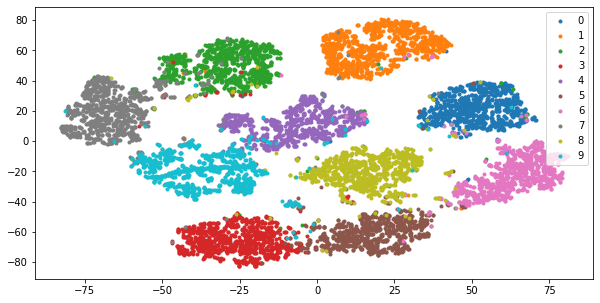

In [64]:
embedding = create_embedding(valid_x, n_components=2, init='pca', random_state=501, metric='cosine')
visualize(embedding, valid_y, 10)

/Users/kenta_suzuki/opt/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train acc:  0.9624
valid acc:  0.9642
macro mean precision:  0.9638841089671064
macro mean recall:  0.964052511011604


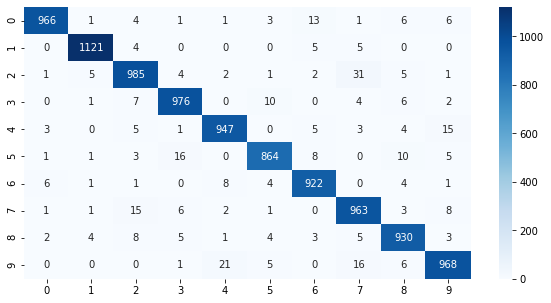

In [65]:
clf = lr(train_x, train_y, valid_x, valid_y)

train acc:  0.9877666666666667
valid acc:  0.9653
macro mean precision:  0.9649158462252598
macro mean recall:  0.9649656289226369


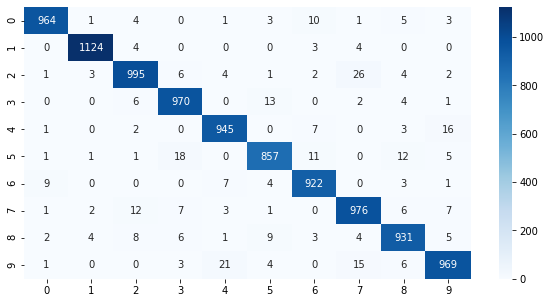

In [66]:
gbm = lightgbm(train_x, train_y, valid_x, valid_y)